# Model Selection

##### *In which we choose the best model to predict the age of a crab.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/1-models)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/1-models/models.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


### Define Constants


In [1]:
%%time
CACHE_FILE = '../cache/crabs.feather'
NEXT_CACHE_FILE = '../cache/splitcrabs.feather'
NEXT_NOTEBOOK = '../2-features/features.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/best_model.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 100
VALIDATION_SPLIT = 0.2


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries


In [2]:
%%time
from notebooks.time_for_crab.mlutils import display_df, plot_training_loss, score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 766 ms
Wall time: 2.29 s


### Load Data from Cache

In the [previous section](../0-eda/overfit.ipynb), we saved the cleaned data to a cache file. Let's load it back.


In [3]:
%%time
crabs = pd.read_feather(CACHE_FILE)
display_df(crabs, show_distinct=True)


DataFrame shape: (3790, 11)
First 5 rows:
     Length  Diameter    Height     Weight  Shucked Weight  Viscera Weight  \
0  1.437500  1.174805  0.412598  24.640625       12.335938        5.585938   
1  0.887695  0.649902  0.212524   5.402344        2.296875        1.375000   
2  1.037109  0.774902  0.250000   7.953125        3.232422        1.601562   
3  1.174805  0.887695  0.250000  13.476562        4.750000        2.281250   
4  0.887695  0.662598  0.212524   6.902344        3.458984        1.488281   

   Shell Weight  Age  Sex_F  Sex_I  Sex_M  
0      6.746094    9   True  False  False  
1      1.559570    6  False  False   True  
2      2.763672    6  False   True  False  
3      5.246094   10   True  False  False  
4      1.701172    6  False   True  False  
<class 'pandas.core.frame.DataFrame'>
Index: 3790 entries, 0 to 3892
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Length          3790 non-nul

### Split the Data

Let's split the data into training and testing sets.

It is important to split the data before any data augmentation or normalization to avoid data leakage.  
Data leakage lets the model learn from the testing data, which can lead to overfitting.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 

#### Importance of Data Shuffling

Shuffling the data is important to avoid any biases in the data.
The order of data shouldn't matter, so shuffling helps mitigate any biases.

Shuffling should occur before the test-train split to be most effective.

We don't have to worry about time-series data right now
(although we could reverse order by 'Age' and call it time-series by new feature 'Crab Birthdate'),
but shuffling can have a big impact on the model's performance.


In [4]:
%%time
# split features from target
X = crabs.drop([PREDICTION_TARGET], axis=1)
y = crabs[PREDICTION_TARGET]

# 80% training, 20% testing
train_size = int((1. - VALIDATION_SPLIT) * len(X))

# shuffle the data
random_indices = np.random.default_rng(42).permutation(np.arange(len(X)))

# split into train/test sets
X_train = X.iloc[random_indices[1:train_size]]
X_test = X.drop(X_train.index)
y_train = y.iloc[random_indices[1:train_size]]
# save the prediction target
y_test = y.drop(y_train.index)

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


X_train: (3031, 10)
X_test: (759, 10)
CPU times: total: 0 ns
Wall time: 2 ms


## Metrics Used

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

#### Max Error

- The max error is the very worst score.
- Lower is better.
- Domain-specific.
- 10 years is a lot for a crab.


## Model Selection

So far, we have not done any feature engineering, which can often be the most important part of the process.
Some new features could be constructed from our dataset which would call for a different model.
Nonetheless, we can start by using all features to set a baseline.
 
We will start with a few simple models to get a baseline accuracy.

We will use the following models:
- Naive Random Baseline
- Linear Regression
- Neural Networks
    - (64-32-16-8-1)
    - (32-16-8-1)
    - (16-8-1)
    - (8-1)
    - (4-1)
    - (2-1) 

### Naive Linear Regression

The simplest model is a naive linear regression model. It is untrained and will make random guesses.


In [5]:
%%time
# layer: input
layer_feature_input = keras.layers.Input(shape=(len(X_train.columns),))

# layer: normalizer
layer_feature_normalizer = keras.layers.Normalization(axis=-1)
layer_feature_normalizer.adapt(np.array(X_train))

# layer: output (linear regression)
layer_feature_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> linear
linear_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    layer_feature_output
])

linear_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32 (132.00 B)

 Trainable params: 11 (44.00 B)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 15.6 ms
Wall time: 50.1 ms


#### Configure the Linear Model

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint


In [6]:
%%time
linear_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

linear_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_linear.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 3 ms


#### Score the Linear Model (Before Training)


In [7]:
%%time
untrained_linear_preds = linear_model.predict(X_test).flatten()
# Utility functions imported from mlutils.py
untrained_linear_scores_df = score_model(untrained_linear_preds, np.array(y_test), index='untrained_linear')
# Add it to the leaderboard
leaderboard_df = score_combine(pd.DataFrame(), untrained_linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step
CPU times: total: 15.6 ms
Wall time: 99.2 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402


#### Train the Linear Model


In [36]:
%%time
linear_history = keras.callbacks.History()

feature_rich_history = linear_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[linear_checkpoint, linear_history]
)


CPU times: total: 1.7 s
Wall time: 6.94 s


#### Score the Linear Model


In [9]:
%%time
linear_preds = linear_model.predict(X_test).flatten()
linear_scores_df = score_model(linear_preds, np.array(y_test), index='linear')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, linear_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
CPU times: total: 0 ns
Wall time: 51.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687


### Neural Network Model

#### Neural Network Architecture

We will start with a deep (64-32-16-8-1) neural network with a few layers, gradually reducing the complexity from our overfit model.

- **Input Layer**
    - All of the features, please.
- **Normalizer Layer**
    - Adapted to all features in the training data. 
- **Hidden Layers**
    - Four dense layers each with 64 >> {layer_index} units and ReLU activation.
- **Output Layer**
    - Layer with one output.


In [10]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 64, 32, 16, 8
num_hidden_layers = 4
layer_deepest_hidden_relu_list = \
    [keras.layers.Dense(units=64>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_deepest_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deepest_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_deepest_hidden_relu_list,
    layer_deepest_output
])

deepest_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,478 (13.59 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 26.6 ms


#### Configure the Neural Network Model

- **Optimizer**
    - Adam: Adaptive Moment Estimation [(Kingma & Ba, 2014)](https://arxiv.org/abs/1412.6980)
- **Loss Function**
    - Mean Squared Error (MSE)
        - This penalizes larger errors more than smaller errors.
        - We took out outliers in the data cleaning step, so this should perform better. 
- **Callbacks**
    - Model Checkpoint


In [11]:
%%time
deepest_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deepest_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_deep.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 1.51 ms


#### Train the Neural Network Model

*We're not going to predict with the untrained model, as we already have a random baseline on the leaderboard.*


In [12]:
%%time
deepest_history = deepest_model.fit(
    x=X_train,
    y=y_train,
    epochs=250,
    verbose=0,
    validation_split=0.2,
    callbacks=[deepest_checkpoint]
)


CPU times: total: 5.42 s
Wall time: 21.5 s


#### Score the Neural Network Model


In [13]:
%%time
deepest_preds = deepest_model.predict(X_test).flatten()
deepest_scores_df = score_model(deepest_preds, np.array(y_test), index='64_32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deepest_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 31.2 ms
Wall time: 107 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520


### Neural Network Model (32-16-8-1)

Let's cut the first layer out and see if it still has what it takes.


In [14]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 32, 16, 8
num_hidden_layers = 3
layer_32_16_8_hidden_relu_list = \
    [keras.layers.Dense(units=32>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_32_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deep_32_16_8_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_32_16_8_hidden_relu_list,
    layer_32_16_8_output
])

deep_32_16_8_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,046 (4.09 KB)

 Trainable params: 1,025 (4.00 KB)

 Non-trainable params: 21 (88.00 B)

CPU times: total: 0 ns
Wall time: 20 ms


#### Configure the (32-16-8-1) Neural Network Model


In [15]:
%%time
deep_32_16_8_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_32_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_32_16_8.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 1.51 ms


#### Train the (32-16-8-1) Neural Network Model

In [16]:
%%time
deep_32_16_8_history = deep_32_16_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_32_16_8_checkpoint]
)


CPU times: total: 2.06 s
Wall time: 9.02 s


#### Score the (32-16-8-1) Neural Network Model


In [17]:
%%time
deep_32_16_8_preds = deep_32_16_8_model.predict(X_test).flatten()
deep_32_16_8_scores_df = score_model(deep_32_16_8_preds, np.array(y_test), index='32_16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_32_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
CPU times: total: 31.2 ms
Wall time: 103 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520
32_16_8_1,3.865775,1.451580,0.158301,0.151004,8.423350


### Neural Network Model (16-8-1)

The last one held up, so let's reduce it even more.


In [18]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 16, 8
num_hidden_layers = 2
layer_16_8_hidden_relu_list = \
    [keras.layers.Dense(units=16>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_16_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deep_16_8_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_16_8_hidden_relu_list,
    layer_16_8_output
])


CPU times: total: 0 ns
Wall time: 10.4 ms


#### Configure the (16-8-1) Neural Network Model


In [19]:
%%time
deep_16_8_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_16_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_16_8.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 999 µs


#### Train the (16-8-1) Neural Network Model


In [20]:
%%time
deep_16_8_history = deep_16_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_16_8_checkpoint]
)


CPU times: total: 2.3 s
Wall time: 8.81 s


#### Score the (16-8-1) Neural Network Model


In [21]:
%%time
deep_16_8_preds = deep_16_8_model.predict(X_test).flatten()
deep_16_8_scores_df = score_model(deep_16_8_preds, np.array(y_test), index='16_8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_16_8_scores_df)
leaderboard_df.head()


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 46.9 ms
Wall time: 89.9 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520
32_16_8_1,3.865775,1.451580,0.158301,0.151004,8.423350
16_8_1,3.841529,1.434516,0.107732,0.107690,8.579039


### Neural Network Model (8-1)

The last reduction didn't lose too much accuracy, so let's continue removing layers.


In [22]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 8
num_hidden_layers = 1
layer_8_hidden_relu_list = \
    [keras.layers.Dense(units=8>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_8_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deep_8_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_8_hidden_relu_list,
    layer_8_output
])


CPU times: total: 0 ns
Wall time: 7.51 ms


#### Configure the (8-1) Neural Network Model


In [23]:
%%time
deep_8_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_8_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_8.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (8-1) Neural Network Model


In [24]:
%%time
deep_8_history = deep_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_8_checkpoint]
)


CPU times: total: 1.78 s
Wall time: 8.29 s


#### Score the (8-1) Neural Network Model


In [25]:
%%time
deep_8_preds = deep_8_model.predict(X_test).flatten()
deep_8_scores_df = score_model(deep_8_preds, np.array(y_test), index='8_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_8_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 86.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520
32_16_8_1,3.865775,1.451580,0.158301,0.151004,8.423350
16_8_1,3.841529,1.434516,0.107732,0.107690,8.579039
8_1,3.835365,1.433632,0.059008,0.056540,9.257305


### Neural Network Model (4-1)

Still not too shabby. Let's reduce the last hidden layer to 4 neurons.


In [26]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 4
num_hidden_layers = 1
layer_4_hidden_relu_list = \
    [keras.layers.Dense(units=4>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_4_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deep_4_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_4_hidden_relu_list,
    layer_4_output
])


CPU times: total: 0 ns
Wall time: 8.52 ms


#### Configure the (4-1) Neural Network Model

In [27]:
%time
deep_4_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_4_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_4.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 0 ns


#### Train the (4-1) Neural Network Model

In [28]:
%%time
deep_4_history = deep_4_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_4_checkpoint]
)


CPU times: total: 2.61 s
Wall time: 8.06 s


#### Score the (4-1) Neural Network Model

In [29]:
%%time
deep_4_preds = deep_4_model.predict(X_test).flatten()
deep_4_scores_df = score_model(deep_4_preds, np.array(y_test), index='4_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_4_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 81.1 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520
32_16_8_1,3.865775,1.451580,0.158301,0.151004,8.423350
16_8_1,3.841529,1.434516,0.107732,0.107690,8.579039
8_1,3.835365,1.433632,0.059008,0.056540,9.257305
4_1,7.756218,2.068487,0.177649,0.067341,13.985075


### Neural Network Model (2-1)

That last one is even worse than random. Should we even try with 2 neurons? Why not?

In [30]:
%%time
# layer: input - reused from linear model
# layer: normalizer - reused from linear model

# layer(s): hidden (relu) - 2
num_hidden_layers = 1
layer_2_hidden_relu_list = \
    [keras.layers.Dense(units=2>>_, activation='relu') for _ in range(num_hidden_layers)]

# layer: output (linear regression)
layer_2_output = keras.layers.Dense(units=1)

# architecture:
#   input -> normalizer -> hidden(s) -> dense
deep_2_model = keras.Sequential([
    layer_feature_input,
    layer_feature_normalizer,
    *layer_2_hidden_relu_list,
    layer_2_output
])


CPU times: total: 0 ns
Wall time: 8.51 ms


#### Configure the (2-1) Neural Network Model

In [31]:
%%time
deep_2_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

deep_2_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE.replace('.keras', '_2.keras'),
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)


CPU times: total: 0 ns
Wall time: 2 ms


#### Train the (2-1) Neural Network Model

In [32]:
%%time
deep_2_history = deep_2_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_2_checkpoint]
)


CPU times: total: 2.5 s
Wall time: 7.91 s


#### Score the (2-1) Neural Network Model

In [33]:
%%time
deep_2_preds = deep_2_model.predict(X_test).flatten()
deep_2_scores_df = score_model(deep_2_preds, np.array(y_test), index='2_1')
# Add it to the leaderboard
leaderboard_df = score_combine(leaderboard_df, deep_2_scores_df)
leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 88.8 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,13.745246,3.096663,-0.243764,-2.994318,13.093687
64_32_16_8_1,3.958045,1.463241,0.307258,0.307031,9.466520
32_16_8_1,3.865775,1.451580,0.158301,0.151004,8.423350
16_8_1,3.841529,1.434516,0.107732,0.107690,8.579039
8_1,3.835365,1.433632,0.059008,0.056540,9.257305
4_1,7.756218,2.068487,0.177649,0.067341,13.985075
2_1,4.098554,1.503558,0.038785,0.038079,9.351641


### Observations

The one with only 2 neurons did better than the one with 4 neurons, but still degraded from the 8+-neuron models.

Let's train for more iterations and draw their training loss.


#### Continue to Train the Models

Give them 500 more epochs each.

##### Linear Model

CPU times: total: 8.2 s
Wall time: 35.2 s


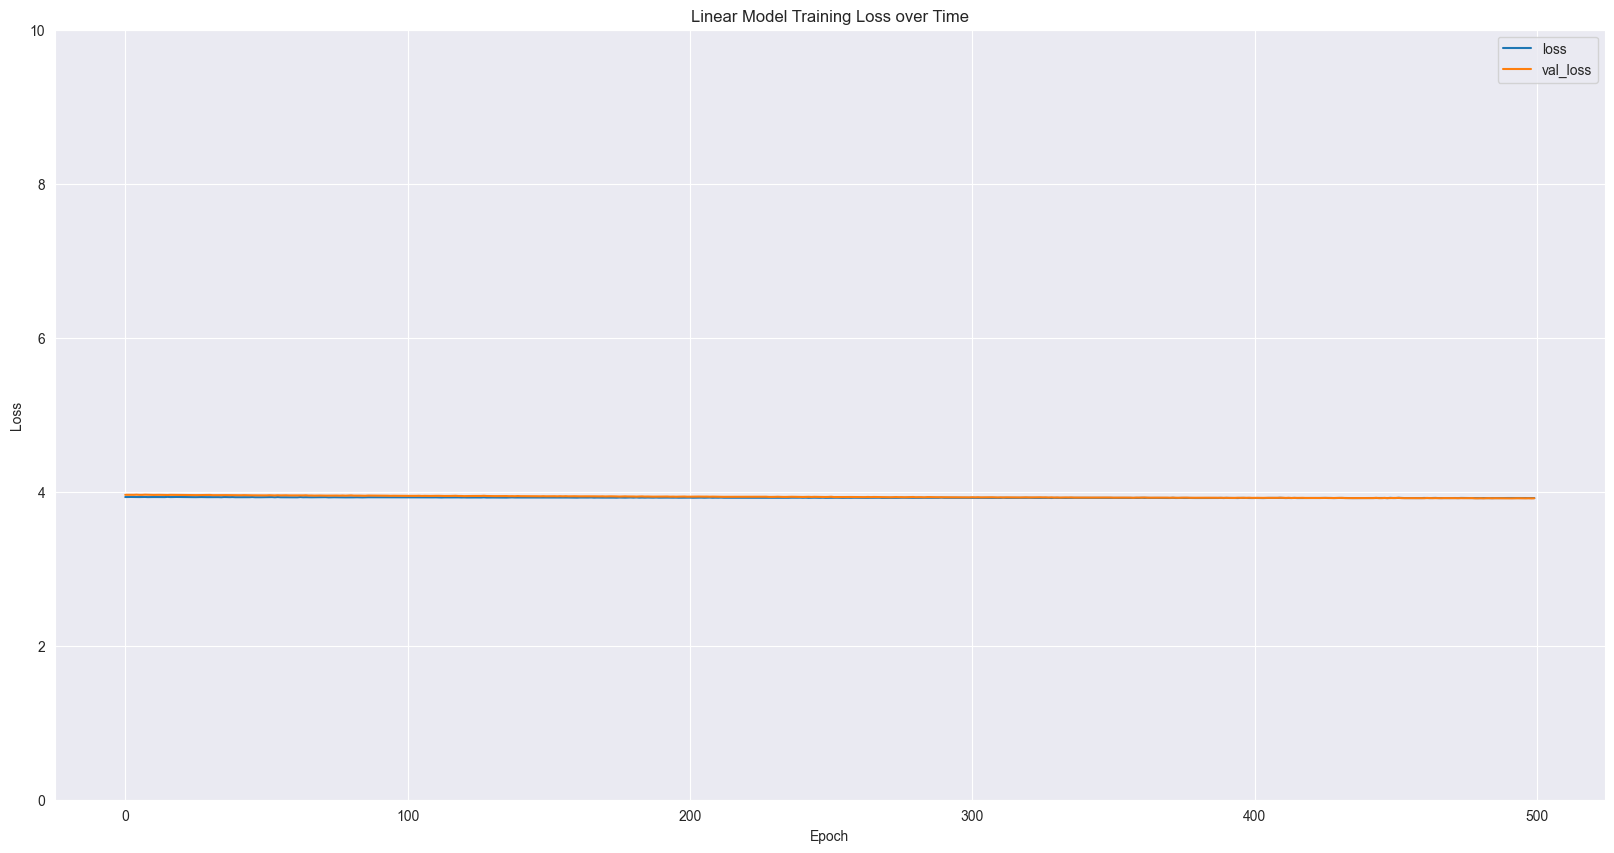

In [38]:
%%time
linear_history = linear_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[linear_checkpoint]
)

plot_training_loss(linear_history, 'Linear Model')


##### Neural Network Model (64-32-16-8-1)

CPU times: total: 7.14 s
Wall time: 39.5 s


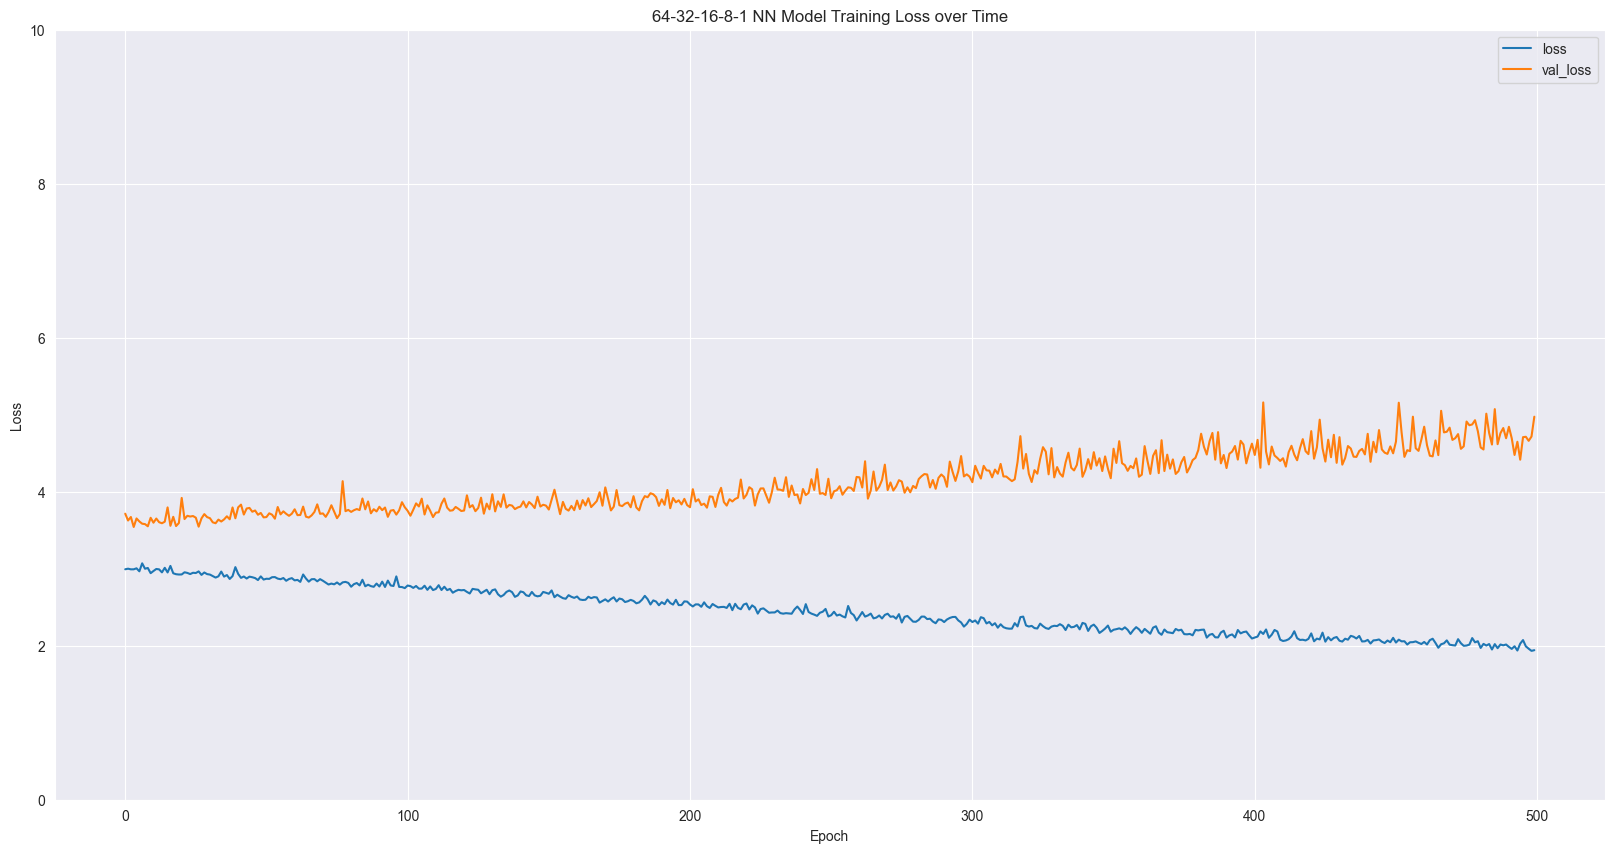

In [39]:
%%time
deepest_history = deepest_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deepest_checkpoint]
)

plot_training_loss(deepest_history, '64-32-16-8-1 NN Model')


(64-32-16-8-1) is overfitting. Let's try the next one.

##### Neural Network Model (32-16-8-1)

CPU times: total: 7.33 s
Wall time: 38.4 s


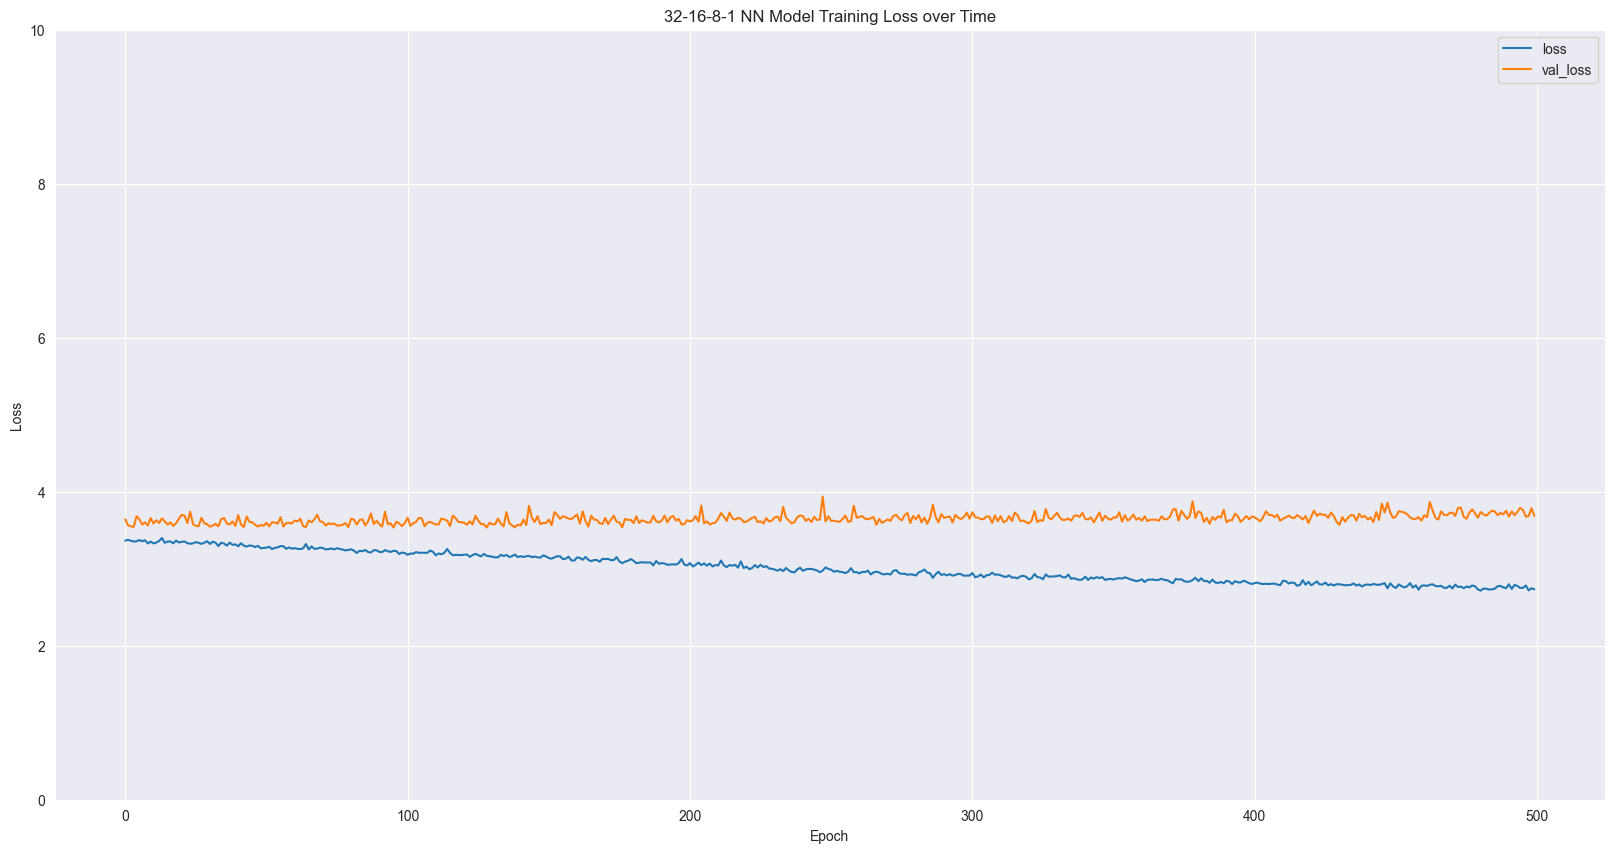

In [40]:
%%time
deep_32_16_8_history = deep_32_16_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_32_16_8_checkpoint]
)

plot_training_loss(deep_32_16_8_history, '32-16-8-1 NN Model')


(32-16-8-1) still overfitting, but not as bad. Let's keep going.

##### Neural Network Model (16-8-1)

CPU times: total: 8.02 s
Wall time: 37.3 s


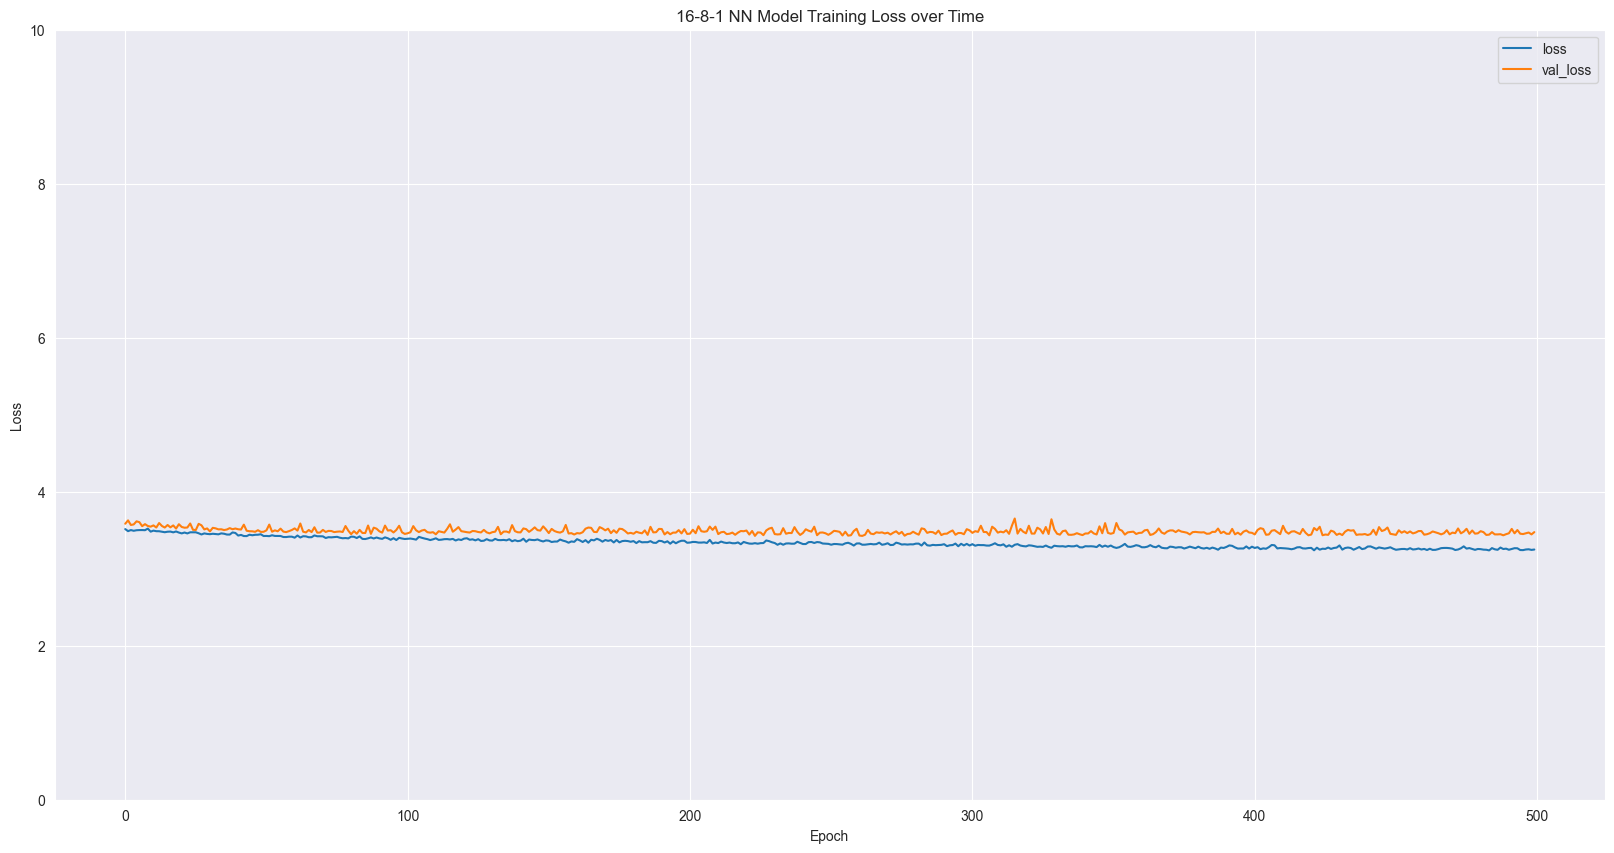

In [41]:
%%time
deep_16_8_history = deep_16_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_16_8_checkpoint]
)

plot_training_loss(deep_16_8_history, '16-8-1 NN Model')


Validation loss is remaining steady, and the training loss is decreasing ever so slightly. It *might* be overfitting, but it's hard to tell.

##### Neural Network Model (8-1)

CPU times: total: 8.78 s
Wall time: 35.9 s


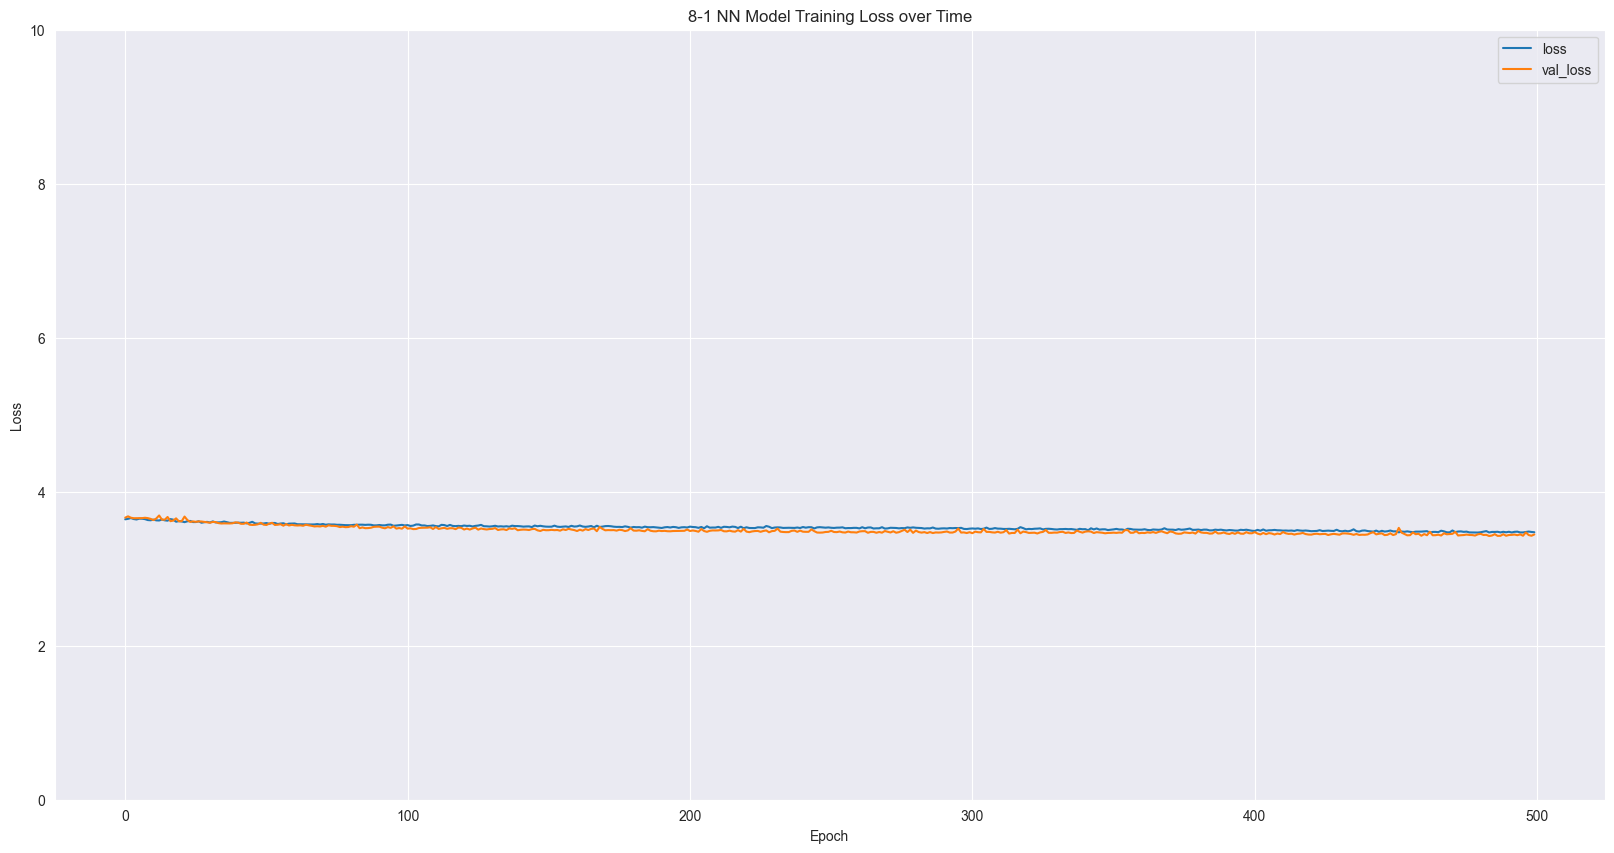

In [42]:
%%time
deep_8_history = deep_8_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_8_checkpoint]
)

plot_training_loss(deep_8_history, '8-1 NN Model')


(8-1) doesn't seem to be overfitting. Let's keep it in mind.

##### Neural Network Model (4-1)

CPU times: total: 8.91 s
Wall time: 37.9 s


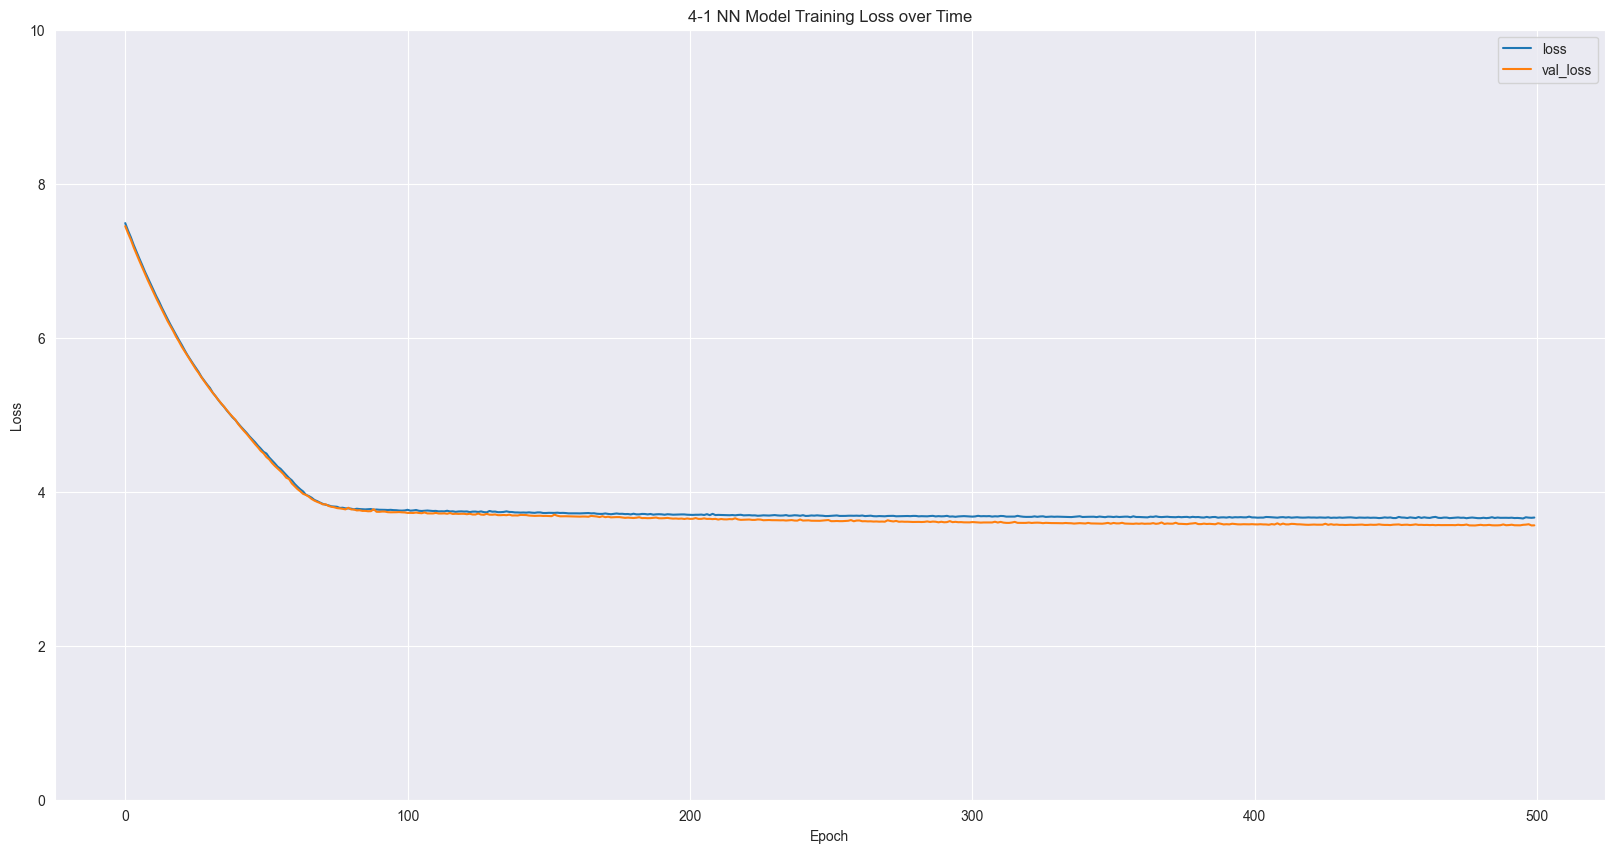

In [43]:
%%time
deep_4_history = deep_4_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_4_checkpoint]
)

plot_training_loss(deep_4_history, '4-1 NN Model')


(4-1) Looks pretty good!

##### Neural Network Model (2-1)

CPU times: total: 8.41 s
Wall time: 34.6 s


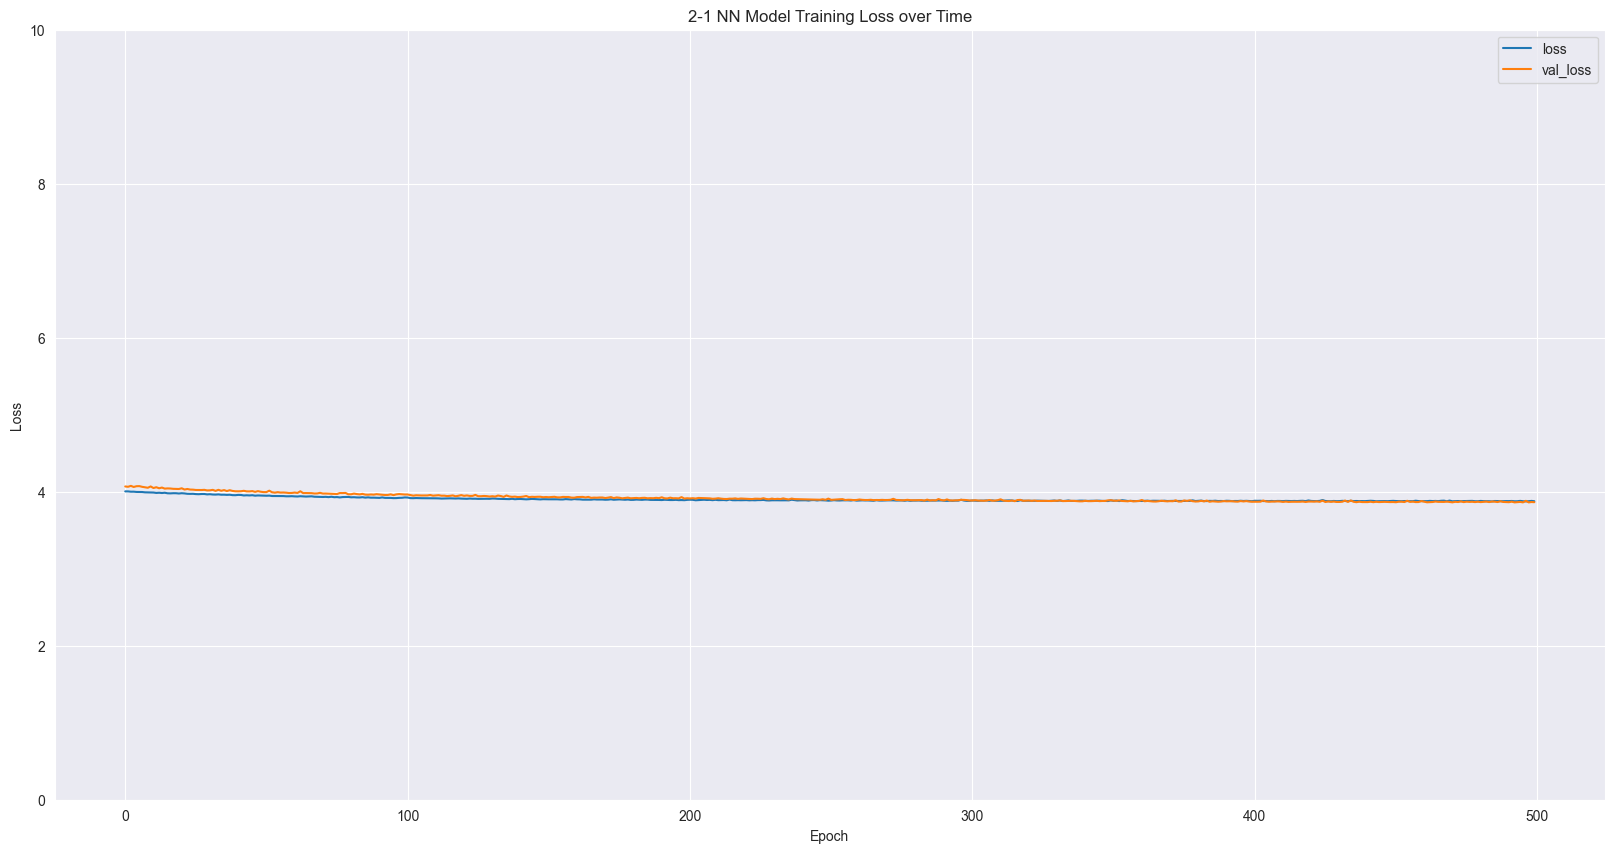

In [44]:
%%time
deep_2_history = deep_2_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS*5,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_2_checkpoint]
)

plot_training_loss(deep_2_history, '2-1 NN Model')


## Model Leaderboard


In [56]:
%%time
# score each model
models = {
    'linear': linear_model,
    '64_32_16_8_1': deepest_model,
    '32_16_8_1': deep_32_16_8_model,
    '16_8_1': deep_16_8_model,
    '8_1': deep_8_model,
    '4_1': deep_4_model,
    '2_1': deep_2_model
}

# score on the test set
for model_name, model in models.items():
    preds = model.predict(X_test).flatten()
    scores_df = score_model(preds, np.array(y_test), index=model_name)
    leaderboard_df = score_combine(leaderboard_df, scores_df)

training_leaderboard_df = leaderboard_df.loc[['untrained_linear']]
# score on the training set
for model_name, model in models.items():
    preds = model.predict(X_train).flatten()
    scores_df = score_model(preds, np.array(y_train), index=model_name+'_train')
    training_leaderboard_df = score_combine(training_leaderboard_df, scores_df)

leaderboard_df[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 416us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 450us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 415us/step
CPU times: total: 297 ms
Wall time: 1.02 s


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,3.969115,1.481492,0.074010,0.073907,9.193447
64_32_16_8_1,6.127015,1.753241,0.222299,0.218671,14.824196
32_16_8_1,4.215706,1.506029,0.235618,0.232342,11.839441
16_8_1,3.833537,1.438958,0.234287,0.234171,8.601788
8_1,3.658628,1.427367,0.276454,0.274999,9.061005
4_1,3.822834,1.445109,0.169932,0.169823,9.188572
2_1,3.924854,1.474334,0.148946,0.148939,9.069064


In [59]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear_train,3.914991,1.471047,0.109083,0.109048,8.345808
64_32_16_8_1_train,2.574148,1.156316,0.647305,0.646192,7.928911
32_16_8_1_train,2.915436,1.263526,0.467057,0.464952,7.638977
16_8_1_train,3.263059,1.320073,0.359011,0.358733,8.826132
8_1_train,3.469911,1.375262,0.330341,0.329008,9.793018
4_1_train,3.630647,1.411146,0.227689,0.227674,8.401493
2_1_train,3.872885,1.463302,0.165208,0.165011,8.291199


### Reminder of Our Metrics

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

#### Max Error

- The max error is the very worst score.
- Lower is better.
- Domain-specific.
- 10 years is a lot for a crab.


### Model Type Comparison

***Note**: Exclude the untrained linear model, MSE, and Max Error from these graphs for clarity.*


CPU times: total: 15.6 ms
Wall time: 24.2 ms


<Axes: title={'center': 'Feature-Rich vs Deep Learning Model Scores'}>

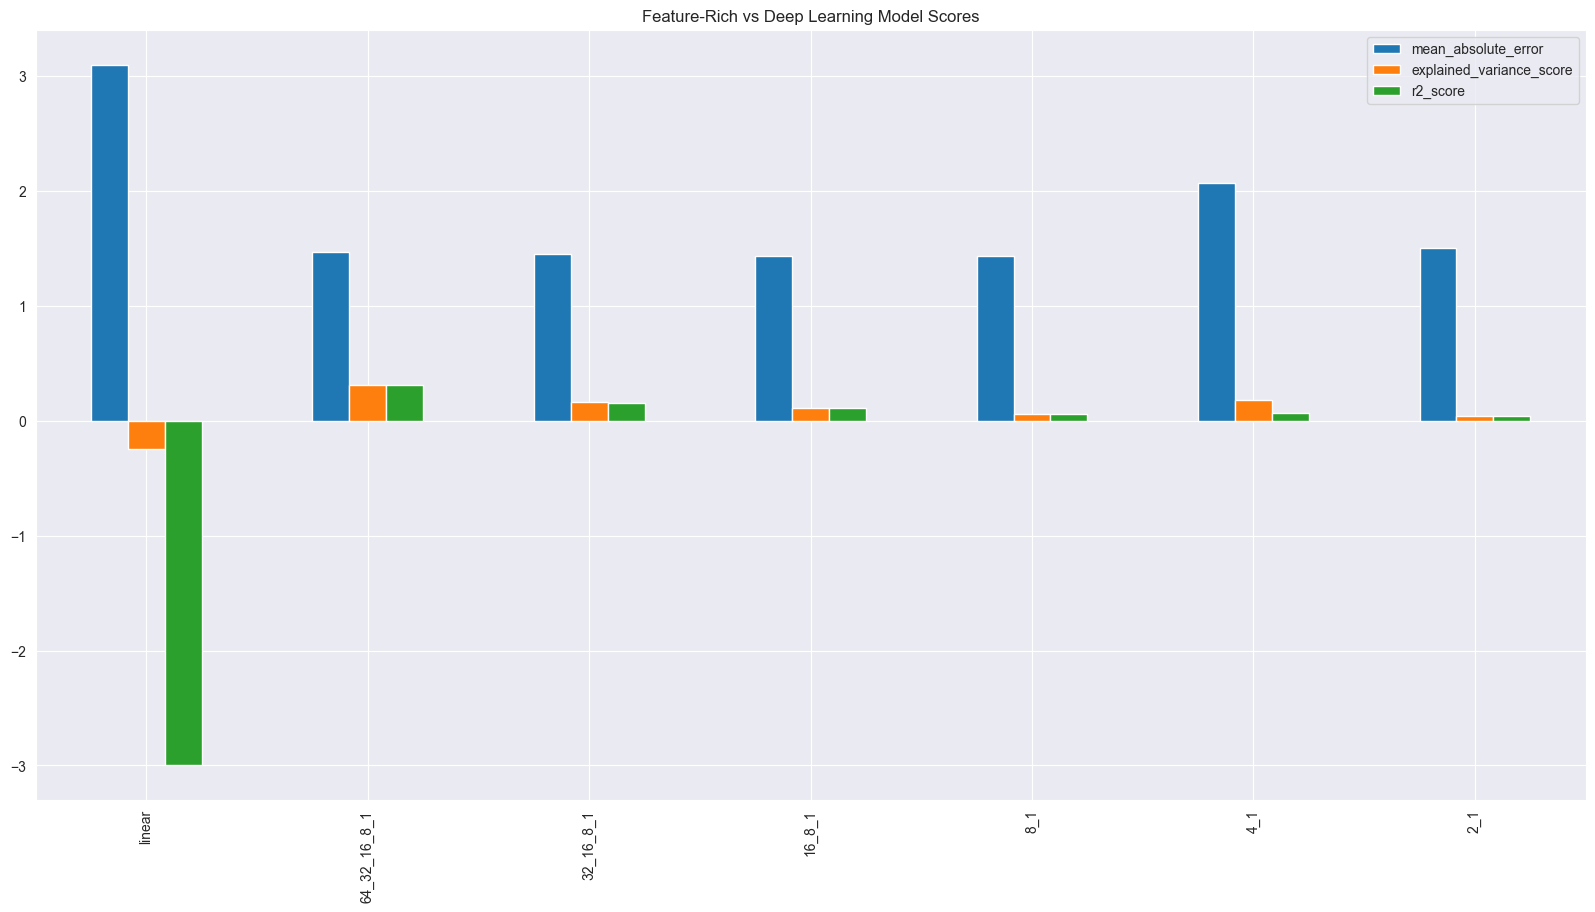

In [49]:
%%time
# exclude the untrained linear model, MSE, and Max Error from this graph for clarity
clarified_leaderboard_df = leaderboard_df.drop('untrained_linear').drop(['mean_squared_error', 'max_error'], axis=1)
clarified_leaderboard_df.plot(kind='bar', title='Feature-Rich vs Deep Learning Model Scores', figsize=(20, 10))


### Overfitting or Underfitting?

Plot the training and testing scores side-by-side to see if the models are overfitting or underfitting.

#### Linear Model

CPU times: total: 31.2 ms
Wall time: 38.1 ms


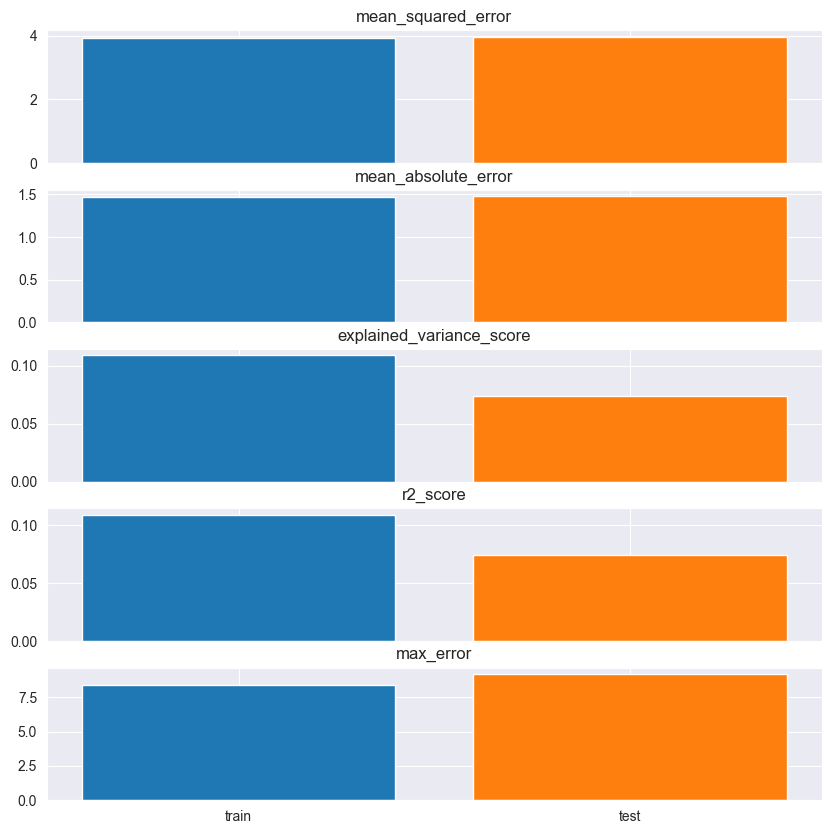

In [67]:
%%time
score_comparator(
    training_leaderboard_df.loc[['linear_train']],
    leaderboard_df.loc[['linear']],
    'linear train',
    'linear test'
)


Linear model might be overfitting.

#### Neural Network Model (64-32-16-8-1)

CPU times: total: 15.6 ms
Wall time: 36.1 ms


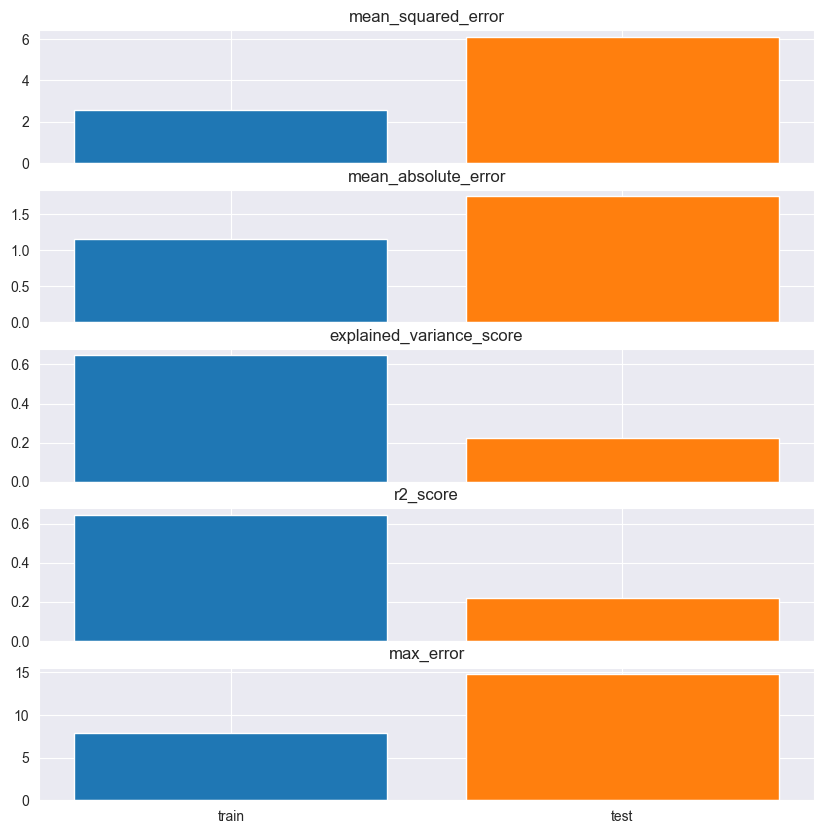

In [68]:
%%time
score_comparator(
    training_leaderboard_df.loc[['64_32_16_8_1_train']],
    leaderboard_df.loc[['64_32_16_8_1']],
    '64_32_16_8_1 train',
    '64_32_16_8_1 test'
)


(64-32-16-8-1) is definitely overfitting.

#### Neural Network Model (32-16-8-1)

CPU times: total: 0 ns
Wall time: 36.2 ms


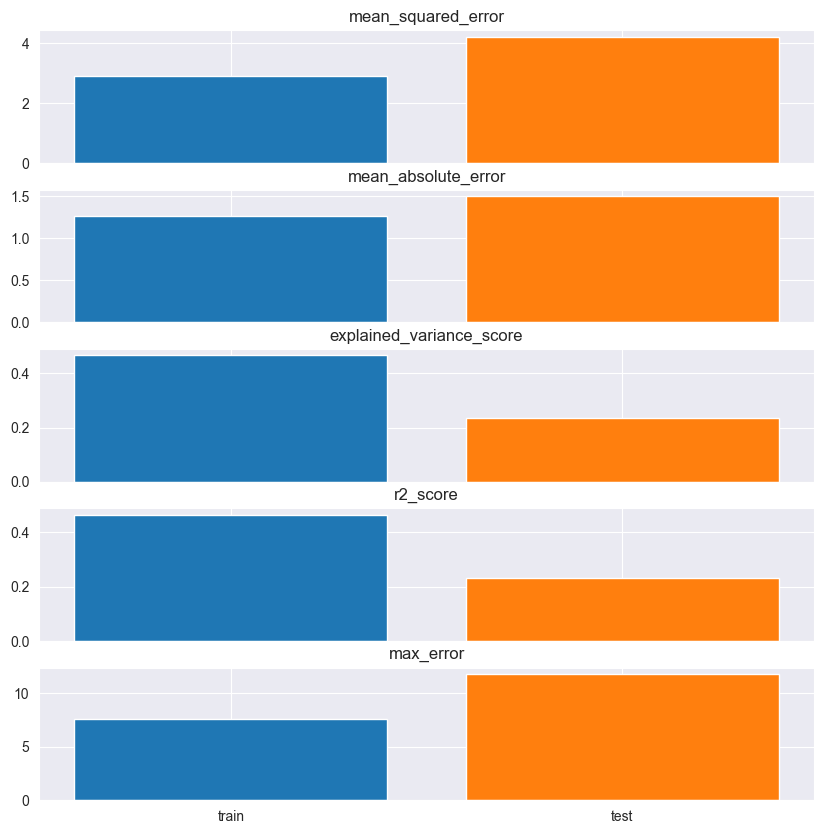

In [69]:
%%time
score_comparator(
    training_leaderboard_df.loc[['32_16_8_1_train']],
    leaderboard_df.loc[['32_16_8_1']],
    '32_16_8_1 train',
    '32_16_8_1 test'
)


(32-16-8-1) is overfitting.

#### Neural Network Model (16-8-1)

CPU times: total: 46.9 ms
Wall time: 35.5 ms


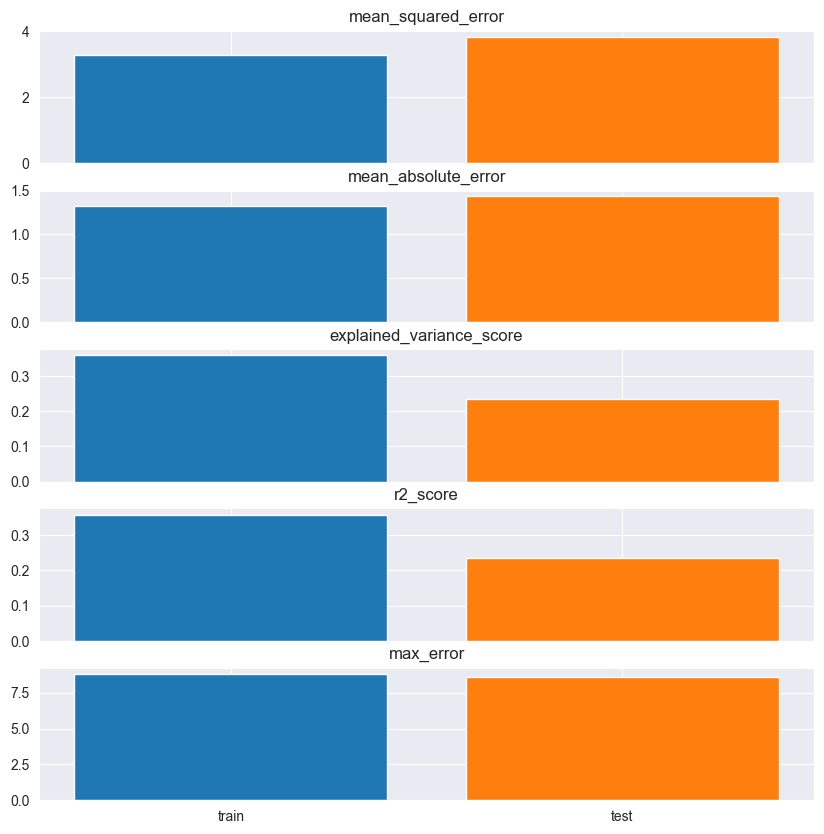

In [71]:
%%time
score_comparator(
    training_leaderboard_df.loc[['16_8_1_train']],
    leaderboard_df.loc[['16_8_1']],
    '16_8_1 train',
    '16_8_1 test'
)


(16-8-1) is overfitting.

#### Neural Network Model (8-1)

CPU times: total: 0 ns
Wall time: 37.6 ms


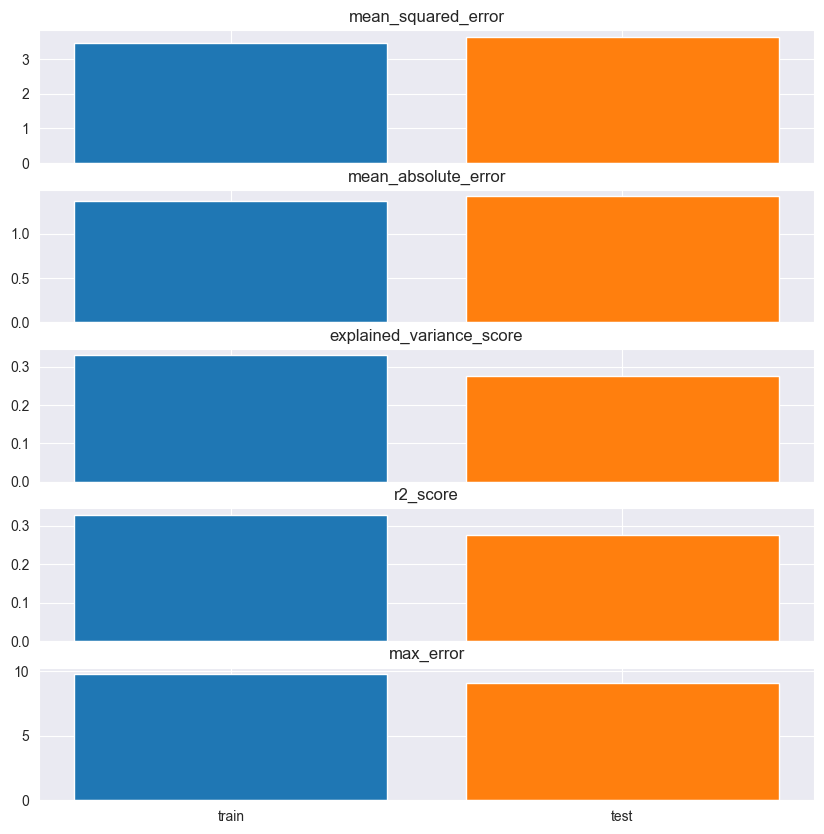

In [72]:
%%time
score_comparator(
    training_leaderboard_df.loc[['8_1_train']],
    leaderboard_df.loc[['8_1']],
    '8_1 train',
    '8_1 test'
)


(8-1) is not overfitting too much.

#### Neural Network Model (4-1)

CPU times: total: 0 ns
Wall time: 34.6 ms


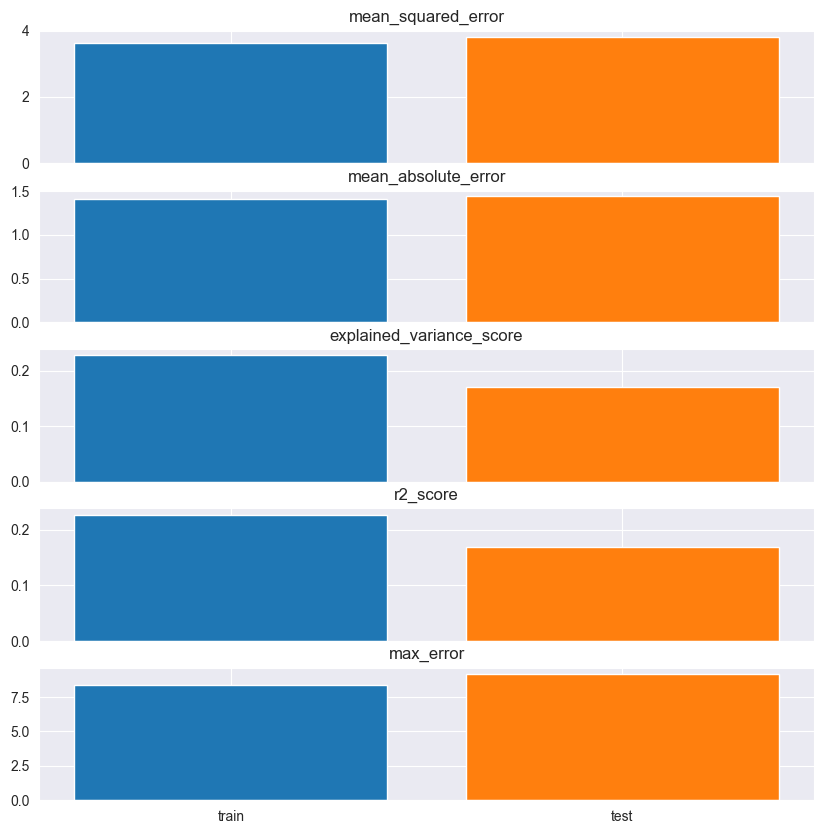

In [73]:
%%time
score_comparator(
    training_leaderboard_df.loc[['4_1_train']],
    leaderboard_df.loc[['4_1']],
    '4_1 train',
    '4_1 test'
)


(4-1) is not overfitting too much either.

#### Neural Network Model (2-1)

CPU times: total: 15.6 ms
Wall time: 36.1 ms


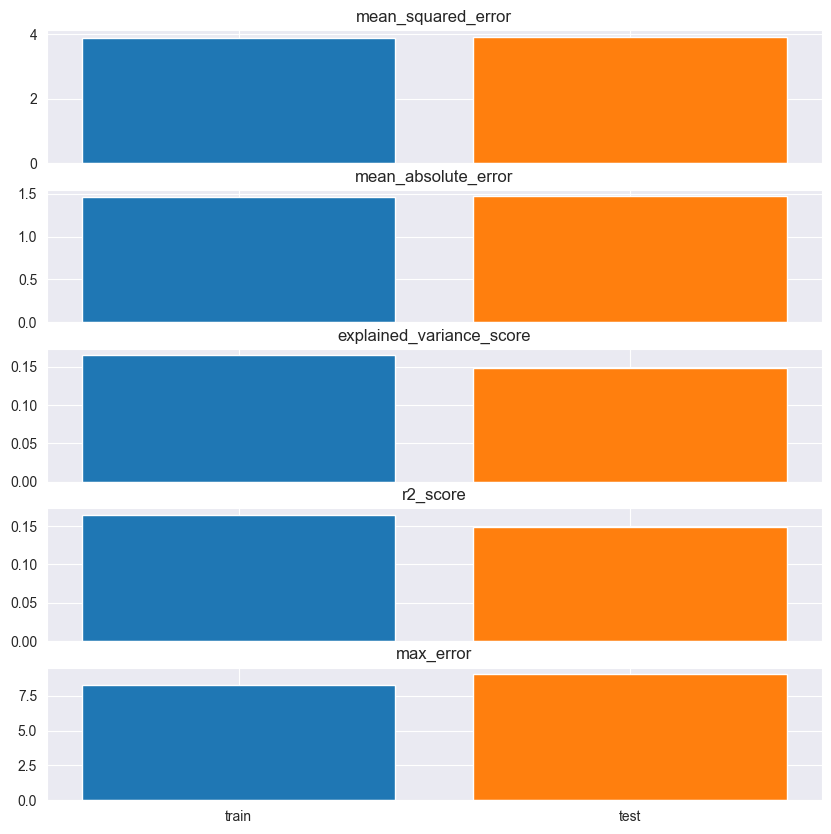

In [74]:
%%time
score_comparator(
    training_leaderboard_df.loc[['2_1_train']],
    leaderboard_df.loc[['2_1']],
    '2_1 train',
    '2_1 test'
)


(2-1) is not overfitting too much either.


### Show the Leaderboard Again

In [75]:
%%time
leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear,3.969115,1.481492,0.074010,0.073907,9.193447
64_32_16_8_1,6.127015,1.753241,0.222299,0.218671,14.824196
32_16_8_1,4.215706,1.506029,0.235618,0.232342,11.839441
16_8_1,3.833537,1.438958,0.234287,0.234171,8.601788
8_1,3.658628,1.427367,0.276454,0.274999,9.061005
4_1,3.822834,1.445109,0.169932,0.169823,9.188572
2_1,3.924854,1.474334,0.148946,0.148939,9.069064


#### On Training Data

Hopefully they did not do much better than their test counterparts.

In [76]:
%%time
training_leaderboard_df[:]


CPU times: total: 0 ns
Wall time: 0 ns


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
untrained_linear,103.869881,9.767563,-8.736025,-118.471594,19.821402
linear_train,3.914991,1.471047,0.109083,0.109048,8.345808
64_32_16_8_1_train,2.574148,1.156316,0.647305,0.646192,7.928911
32_16_8_1_train,2.915436,1.263526,0.467057,0.464952,7.638977
16_8_1_train,3.263059,1.320073,0.359011,0.358733,8.826132
8_1_train,3.469911,1.375262,0.330341,0.329008,9.793018
4_1_train,3.630647,1.411146,0.227689,0.227674,8.401493
2_1_train,3.872885,1.463302,0.165208,0.165011,8.291199


#### Score These Scores

Why not?

These scores will show the level of similarity between the prediction on the test set vs. the training set.

This could be a good way to see if the model is overfitting or underfitting.


In [91]:
%%time
score_score_leaderboard_df = pd.DataFrame()

for model_name in leaderboard_df.index:
    if model_name == 'untrained_linear':
        continue
    score_score_leaderboard_df = score_combine(
        score_score_leaderboard_df,
        score_model(
            leaderboard_df.loc[[model_name]].transpose(),
            training_leaderboard_df.loc[[f'{model_name}_train']].transpose(), index=model_name
        )
    )

score_score_leaderboard_df[:]


CPU times: total: 31.2 ms
Wall time: 45.6 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score,max_error
linear,0.144799,0.196484,0.990085,0.987670,0.847639
64_32_16_8_1,12.177508,2.379521,0.738401,0.602889,6.895285
32_16_8_1,3.900216,1.241457,0.853879,0.795398,4.200464
16_8_1,0.084196,0.232598,0.991721,0.991534,0.570478
8_1,0.115999,0.216146,0.990669,0.989352,0.732014
4_1,0.132853,0.225767,0.991235,0.988428,0.787079
2_1,0.121684,0.174640,0.991510,0.989186,0.777865


## Choose the Best Model for the Job

Those pesky crabs don't want us to know how old they are. We'll find out soon enough.

First, let's choose the best model for the job.

Based on low MSE, high R2, and high Explained Variance, low max error, the best model is the (8-1) neural network model.

### Pursue the (8-1) Neural Network Model

Let's try some hyperparameter tuning on the (8-1) neural network model.


## Hyperparameter Tuning

Next, we will tune the hyperparameters of the (8-1) neural network model.

### Schedule the Learning Rate

Let's use what we learned from [simulated annealing](https://github.com/ahester57/ai_workshop/tree/master/notebooks/simulated_annealing) to schedule the learning rate.


In [112]:
%%time
deep_model = keras.models.clone_model(deep_8_model)

learning_rate_schedule = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=6,
    verbose=1,
    mode='min'
)

deep_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error'
)


deep_model_history = deep_model.fit(
    x=X_train,
    y=y_train,
    epochs=NUM_EPOCHS,
    verbose=0,
    validation_split=VALIDATION_SPLIT,
    callbacks=[deep_8_checkpoint, learning_rate_schedule]
)



Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
CPU times: total: 2.19 s
Wall time: 7.3 s


#### Plot the Training Loss

CPU times: total: 0 ns
Wall time: 8.51 ms


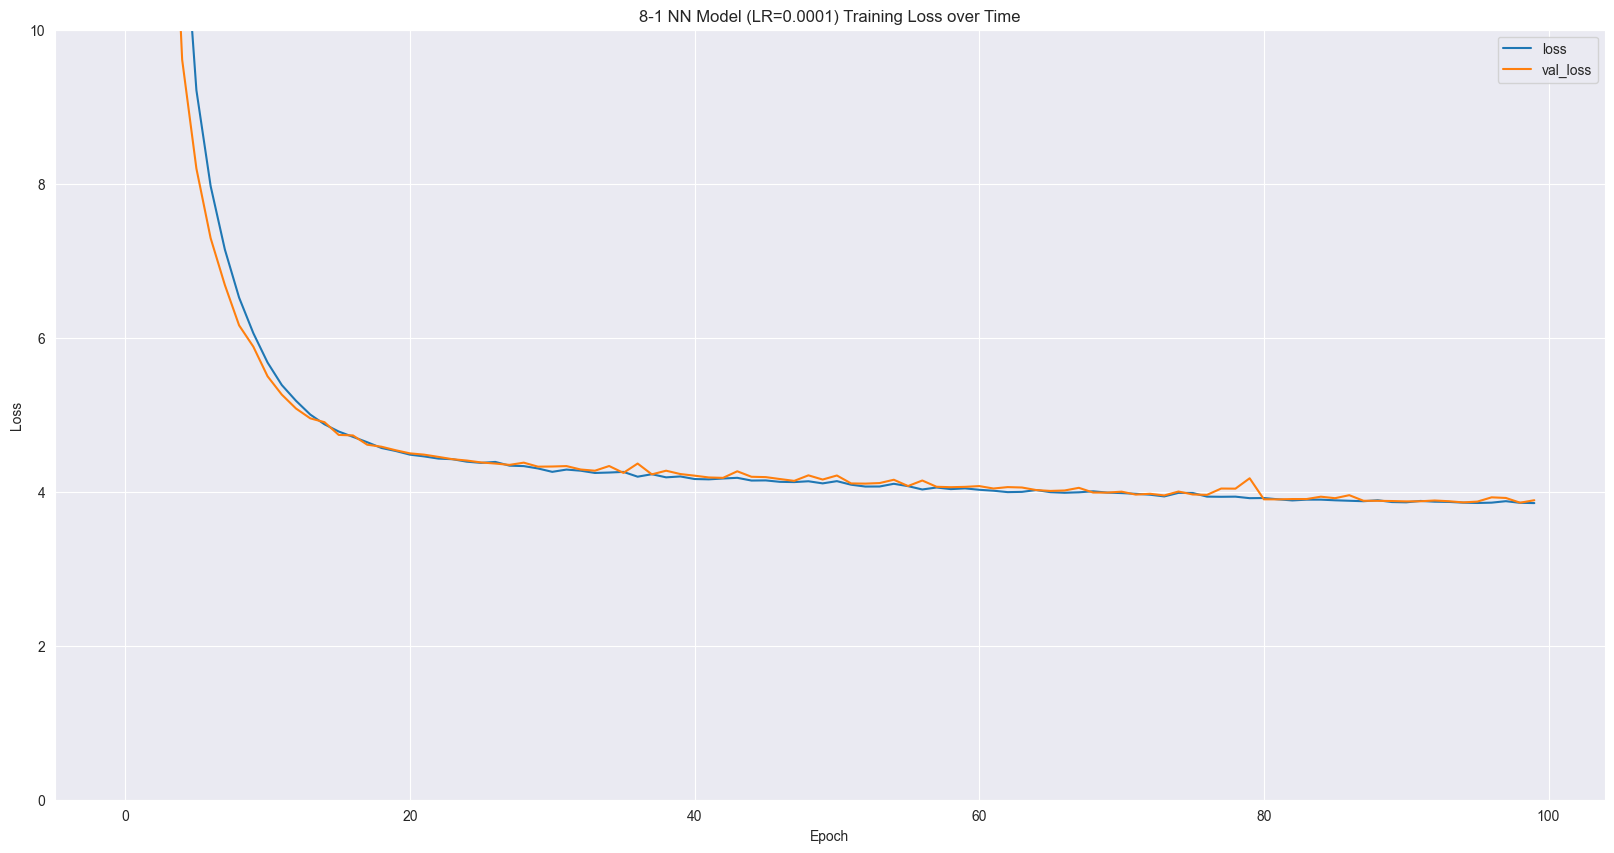

In [113]:
%%time
plot_training_loss(deep_model_history, '8-1 NN Model (LR=0.0001)')


## Save the Data

So we can pick this back up on the [next step](../2-features/features.ipynb).


In [35]:
%%time
# save the training and test data separately
pd.concat([X_train, y_train], axis=1, join='outer').to_feather(NEXT_CACHE_FILE)
pd.concat([X_test, y_test], axis=1, join='outer').to_feather(NEXT_CACHE_FILE.replace('.feather', '_test.feather'))


CPU times: total: 0 ns
Wall time: 5.52 ms


## Onwards to Feature Engineering

See the [next section](../2-features/features.ipynb) for feature engineering.

[`<html link>`](https://nbviewer.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/2-features/features.ipynb) for feature reduction.
